In [ ]:
!nvidia-smi

Thu Jun 27 02:12:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q ultralytics supervision==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 63.1 MB/s eta 0:00:00


## Imports

In [ ]:
import numpy as np
import supervision as sv

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

## Download video

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd {HOME}
Input ='/content/drive/MyDrive/videotrackandcount.mp4'

/content


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/drive/MyDrive/videotrackandcount.mp4"

## Read single frame from video

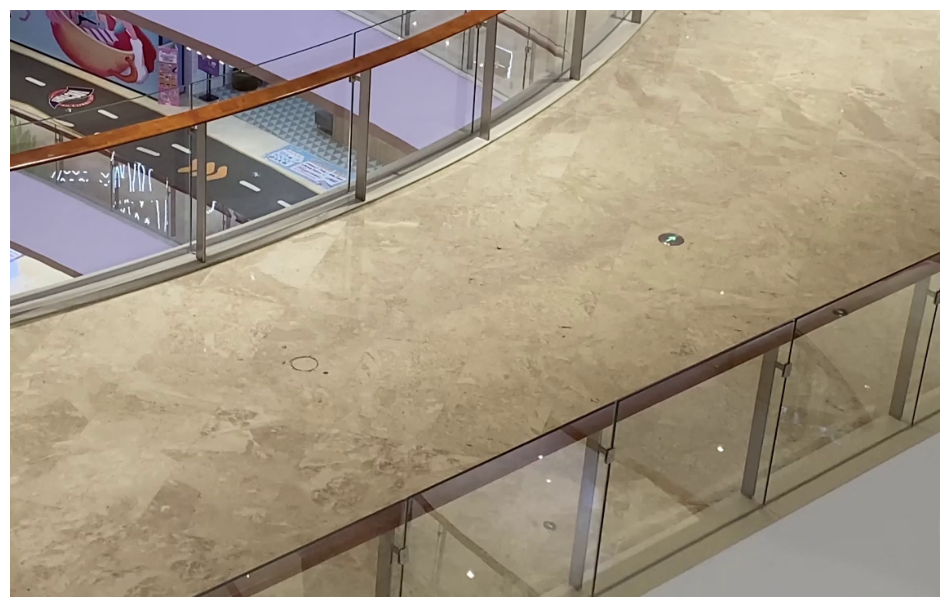

In [ ]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1140, height=720, fps=30, total_frames=5317)

## Run Object Detection

Let's start by running the detection model on the first frame and annotating the results. In this cookbook, we use [Ultralytics](https://github.com/ultralytics/ultralytics) YOLOv8, but it can be successfully replaced with [other models](https://supervision.roboflow.com/latest/detection/core).

We initiate the model and perform detection on the first frame of the video. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [ ]:
model = YOLO("yolov8x.pt")

results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 131M/131M [00:01<00:00, 94.9MB/s]



The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator). By default, this annotator uses the same color to highlight objects of the same category. However, with the integration of a [tracker](https://supervision.roboflow.com/latest/trackers/), it becomes possible to assign unique colors to each tracked object. We can easily define our [own color palettes](https://supervision.roboflow.com/latest/draw/color/#supervision.draw.color.ColorPalette) and adjust parameters such as line thickness, allowing for a highly tailored visualization experience.

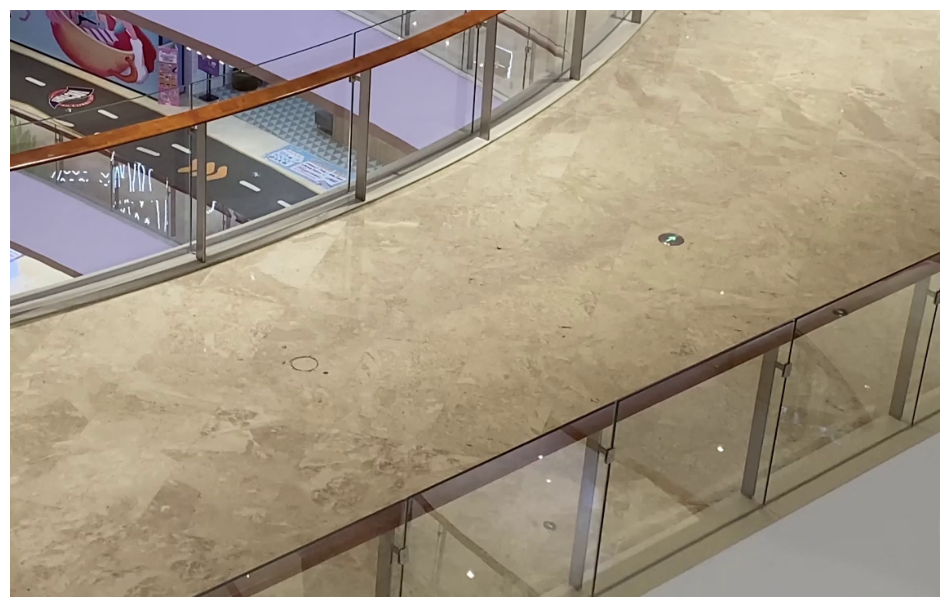

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

## Improve Vizualizations

Supervision annotators can be easily combined with one another. Let's enhance our visualization by adding [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.PolygonAnnotator.annotate), which we will use to mark detections with a label indicating their category and confidence level.

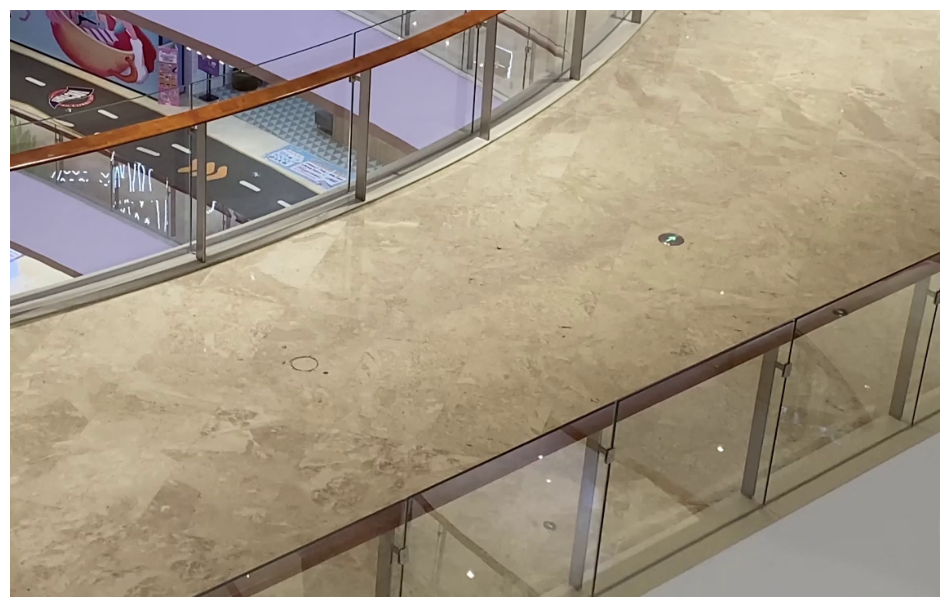

In [ ]:
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

## Define Line Position

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1140, height=720, fps=30, total_frames=5317)

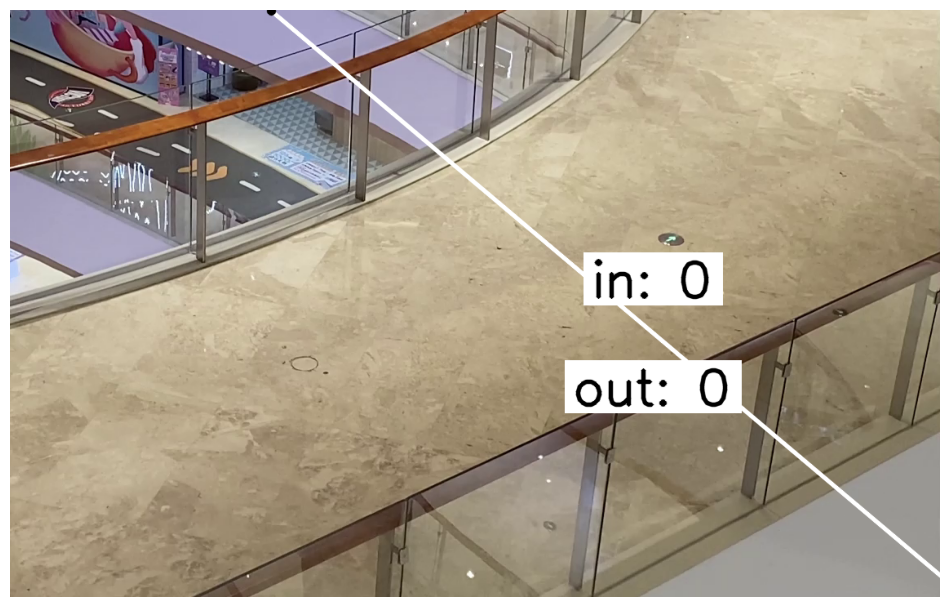

In [ ]:
START = sv.Point(320, 2)
END = sv.Point(1256, 791) #[356, 19],[1256, 791]

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4,
    text_thickness=4,
    text_scale=2)

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

## Process Video

In [ ]:
byte_tracker = sv.ByteTrack()

In [ ]:
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)
trace_annotator = sv.TraceAnnotator(thickness=4)

In [ ]:
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    line_zone.trigger(detections)

    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/count-objects-crossing-the-line-result.mp4"

In [ ]:
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

In [ ]:
import supervision as sv
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

for frame in frames_generator:

    results = model(frame)[0]
    detections = sv.Detections.from_ultralytics(results)

100%|██████████| 6.23M/6.23M [00:00<00:00, 22.7MB/s]


Streaming output truncated to the last 5000 lines.
0: 416x640 (no detections), 10.1ms
Speed: 3.9ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 10.2ms
Speed: 3.2ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 12.4ms
Speed: 3.0ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 11.8ms
Speed: 5.5ms preprocess, 11.8ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 14.7ms
Speed: 7.2ms preprocess, 14.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 14.6ms
Speed: 3.7ms preprocess, 14.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detections), 9.1ms
Speed: 4.6ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 (no detec